In [1]:
# cellule 1 : Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
# cellule 2 : Chargement
X_train = pd.read_csv("X_train_scaled-v2.csv")
X_val = pd.read_csv("X_val_scaled-v2.csv")
X_test = pd.read_csv("X_test_scaled-v2.csv")
y_train = pd.read_csv("y_train-v2.csv").squeeze()
y_val = pd.read_csv("y_val-v2.csv").squeeze()
y_test = pd.read_csv("y_test-v2.csv").squeeze()


In [3]:
# cellule 3 : Fonctions métriques
def metrics_log(y_true_log, y_pred_log):
    return {
        "RMSE_log": np.sqrt(mean_squared_error(y_true_log, y_pred_log)),
        "MAE_log": mean_absolute_error(y_true_log, y_pred_log),
        "R2_log": r2_score(y_true_log, y_pred_log),
    }

def metrics_dollar(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return {
        "RMSE_$": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE_$": mean_absolute_error(y_true, y_pred),
        "R2_$": r2_score(y_true, y_pred),
    }


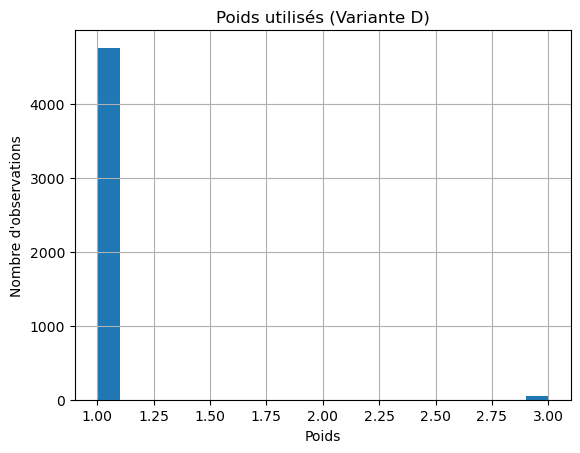

In [4]:
# cellule 4 : Pondération fine (3 variantes)

# Merge train + val
X_final_train = pd.concat([X_train, X_val])
y_final_train = pd.concat([y_train, y_val])

# Percentile
percentiles = y_final_train.rank(pct=True)

# Choisir UNE SEULE variante à la fois (A, B ou C)
variant = "D"

if variant == "A":
    weights = 1 - 0.8 * (percentiles ** 4)
elif variant == "B":
    weights = 1 - 0.5 * (percentiles ** 2)
elif variant == "C":
    weights = np.where(np.expm1(y_final_train) >= 1_000_000, 2.0, 1.0)
elif variant == "D":
    percentiles = y_final_train.rank(pct=True)
    weights = 1 + 2.0 * (percentiles >= 0.99).astype(float)


plt.hist(weights, bins=20)
plt.title(f"Poids utilisés (Variante {variant})")
plt.xlabel("Poids")
plt.ylabel("Nombre d'observations")
plt.grid()
plt.show()


In [5]:
# cellule 5 : RandomizedSearchCV

param_distributions = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.03, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 2]
}

xgb_base = XGBRegressor(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    objective='reg:pseudohubererror',
    eval_metric='rmse',
    random_state=42,
    n_jobs=-1
)

search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=20,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

search.fit(X_final_train, y_final_train, sample_weight=weights)
print("Meilleurs hyperparamètres :", search.best_params_)
print("Score CV (RMSE log) :", -search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Meilleurs hyperparamètres : {'subsample': 0.6, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.03, 'colsample_bytree': 0.6}
Score CV (RMSE log) : 0.2544497612747618


In [6]:
# cellule 6 : Réentraînement avec sample_weight

final_model = XGBRegressor(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    objective='reg:pseudohubererror',
    eval_metric='rmse',
    random_state=42,
    n_jobs=-1,
    **search.best_params_
)

final_model.fit(X_final_train, y_final_train, sample_weight=weights)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
             objective='reg:pseudohubererror', predictor='gpu_predictor', ...)

In [7]:
# cellule 7 : evaluation

print("=== MÉTRIQUES TEST ===")
y_test_pred = final_model.predict(X_test)
print(metrics_log(y_test, y_test_pred))
print(metrics_dollar(y_test, y_test_pred))


=== MÉTRIQUES TEST ===
{'RMSE_log': np.float64(0.29532835589572015), 'MAE_log': np.float64(0.16122159345109616), 'R2_log': np.float64(0.7803913391754855)}
{'RMSE_$': np.float64(119062.94159604704), 'MAE_$': np.float64(56085.00366901901), 'R2_$': np.float64(0.8457598575879424)}


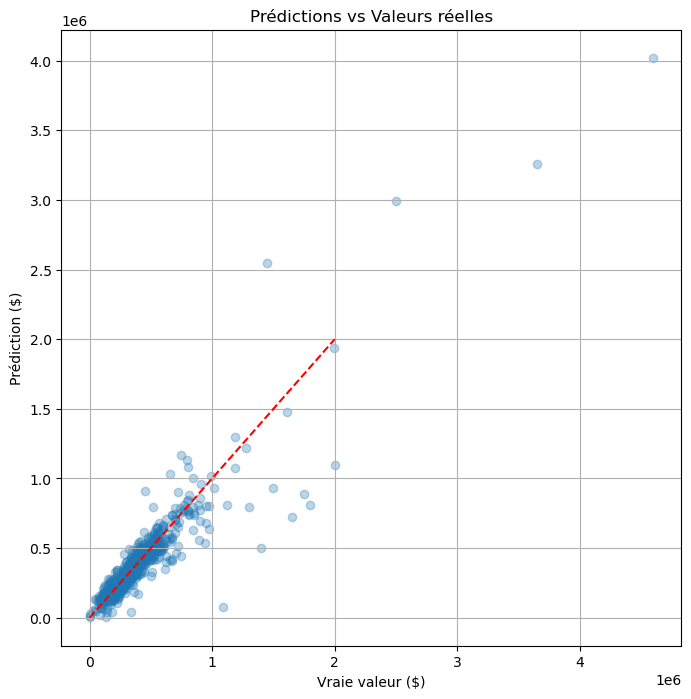

In [8]:
# cellule 8 : Visualisation finale

plt.figure(figsize=(8, 8))
plt.scatter(np.expm1(y_test), np.expm1(y_test_pred), alpha=0.3)
plt.plot([0, 2_000_000], [0, 2_000_000], color='red', linestyle='--')
plt.xlabel("Vraie valeur ($)")
plt.ylabel("Prédiction ($)")
plt.title("Prédictions vs Valeurs réelles")
plt.grid()
plt.show()


In [9]:
# MAE pour maisons < 1 million $ et >= 1 million $
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_test_pred)

# Masques
mask_under_1M = y_test_exp < 1_000_000
mask_over_1M = y_test_exp >= 1_000_000

# MAE $ par segment
mae_under_1M = mean_absolute_error(y_test_exp[mask_under_1M], y_pred_exp[mask_under_1M])
mae_over_1M = mean_absolute_error(y_test_exp[mask_over_1M], y_pred_exp[mask_over_1M])

# Résultats
print(f"MAE pour maisons < 1M$ : {mae_under_1M:,.0f} $")
print(f"MAE pour maisons ≥ 1M$ : {mae_over_1M:,.0f} $")


MAE pour maisons < 1M$ : 45,195 $
MAE pour maisons ≥ 1M$ : 531,241 $


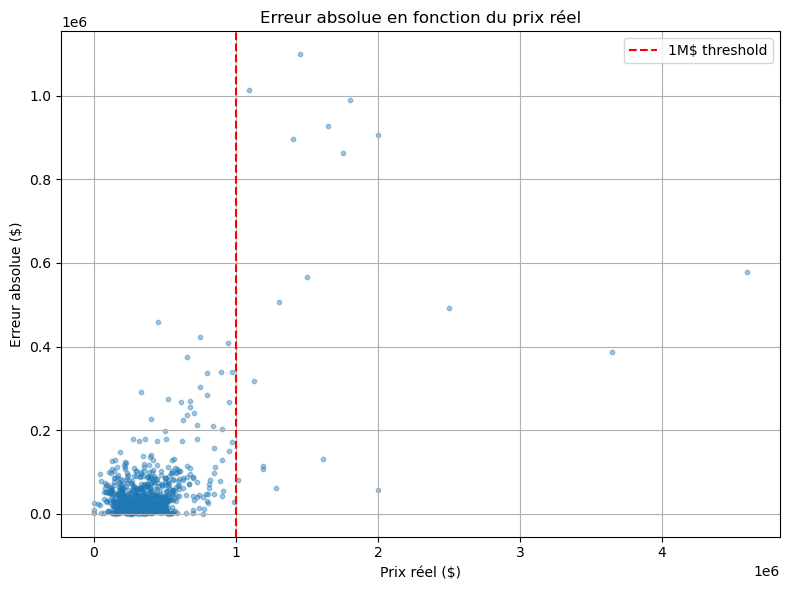

In [10]:
import matplotlib.pyplot as plt

errors = np.abs(y_test_exp - y_pred_exp)

plt.figure(figsize=(8, 6))
plt.scatter(y_test_exp, errors, alpha=0.4, s=10)
plt.axvline(1_000_000, color='red', linestyle='--', label='1M$ threshold')
plt.xlabel("Prix réel ($)")
plt.ylabel("Erreur absolue ($)")
plt.title("Erreur absolue en fonction du prix réel")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# MAE pour maisons < 2 million $ et >= 2 million $
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_test_pred)

# Masques
mask_under_2M = y_test_exp < 2_000_000
mask_over_2M = y_test_exp >= 2_000_000

# MAE $ par segment
mae_under_2M = mean_absolute_error(y_test_exp[mask_under_2M], y_pred_exp[mask_under_2M])
mae_over_2M = mean_absolute_error(y_test_exp[mask_over_2M], y_pred_exp[mask_over_2M])

# Résultats
print(f"MAE pour maisons < 2M$ : {mae_under_2M:,.0f} $")
print(f"MAE pour maisons ≥ 2M$ : {mae_over_2M:,.0f} $")


MAE pour maisons < 2M$ : 54,559 $
MAE pour maisons ≥ 2M$ : 485,996 $


In [12]:
# MAE pour maisons < 1.5 million $ et >= 1.5 million $
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_test_pred)

# Masques
mask_under_M = y_test_exp < 1_500_000
mask_over_M = y_test_exp >= 1_500_000

# MAE $ par segment
mae_under_M = mean_absolute_error(y_test_exp[mask_under_M], y_pred_exp[mask_under_M])
mae_over_M = mean_absolute_error(y_test_exp[mask_over_M], y_pred_exp[mask_over_M])

# Résultats
print(f"MAE pour maisons < 1.5M$ : {mae_under_M:,.0f} $")
print(f"MAE pour maisons ≥ 1.5M$ : {mae_over_M:,.0f} $")


MAE pour maisons < 1.5M$ : 50,333 $
MAE pour maisons ≥ 1.5M$ : 592,339 $


In [13]:
df = pd.read_csv("df_clean.csv")
df.head()

,zpid,sale_price,bedrooms,bathrooms,living_area,year_built,zipcode,lat,lon,distance_to_downtown_km,...,zipcode_46256.0,zipcode_46259.0,zipcode_46260.0,zipcode_46268.0,zipcode_46278.0,zipcode_46280.0,zipcode_46290.0,log_sale_price,log_living_area,log_house_age
0,1077522,78000.0,2.0,1.0,1816.0,1918.0,46201.0,39.761307,-86.116610,3.632917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.264477,7.504942,4.691348
1,1085356,245000.0,2.0,2.0,2206.0,1910.0,46201.0,39.780403,-86.123510,3.243433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.409018,7.699389,4.762174
2,1104044,95200.0,3.0,1.0,2066.0,1920.0,46201.0,39.777847,-86.096085,5.403062,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.463746,7.633854,4.672829
3,1108751,149000.0,2.0,2.0,1260.0,1955.0,46201.0,39.760080,-86.115610,3.747756,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.911708,7.139660,4.276666
4,1082586,150000.0,2.0,1.0,1824.0,1925.0,46201.0,39.763660,-86.091415,5.723979,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.918397,7.509335,4.624973


In [14]:
pourcentage_luxury = (df['sale_price'] >= 1_000_000).mean() * 100
print(f"Part des maisons >= 1M$ : {pourcentage_luxury:.2f} %")


Part des maisons >= 1M$ : 2.76 %


In [15]:
# cv detaillee

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Conversion pour éviter les erreurs d’indexation
weights = np.array(weights)

quantiles = pd.qcut(y_final_train, q=5, labels=False)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rmse_log_scores = []
rmse_dollar_scores = []
mae_dollar_scores = []

mae_under_1M_list = []
mae_over_1M_list = []
n_under_1M_list = []
n_over_1M_list = []

print("=== VALIDATION CROISÉE (stratifiée avec tranches de prix) ===")

for fold, (train_idx, val_idx) in enumerate(cv.split(X_final_train, quantiles), 1):
    X_tr, X_val = X_final_train.iloc[train_idx], X_final_train.iloc[val_idx]
    y_tr, y_val = y_final_train.iloc[train_idx], y_final_train.iloc[val_idx]
    w_tr = weights[train_idx]  # pas .iloc car ndarray

    model = XGBRegressor(
        tree_method='gpu_hist',
        predictor='gpu_predictor',
        objective='reg:pseudohubererror',
        eval_metric='rmse',
        random_state=42,
        n_jobs=-1,
        **search.best_params_
    )
    model.fit(X_tr, y_tr, sample_weight=w_tr)

    y_val_pred_log = model.predict(X_val)
    y_val_pred_dollar = np.expm1(y_val_pred_log)
    y_val_dollar = np.expm1(y_val)

    # Global
    rmse_log = np.sqrt(mean_squared_error(y_val, y_val_pred_log))
    rmse_dollar = np.sqrt(mean_squared_error(y_val_dollar, y_val_pred_dollar))
    mae_dollar = mean_absolute_error(y_val_dollar, y_val_pred_dollar)

    # Découpage <1M / ≥1M
    mask_under_1M = y_val_dollar < 1_000_000
    mask_over_1M = ~mask_under_1M

    mae_under_1M = mean_absolute_error(y_val_dollar[mask_under_1M], y_val_pred_dollar[mask_under_1M])
    mae_over_1M = mean_absolute_error(y_val_dollar[mask_over_1M], y_val_pred_dollar[mask_over_1M])

    # Enregistrement
    rmse_log_scores.append(rmse_log)
    rmse_dollar_scores.append(rmse_dollar)
    mae_dollar_scores.append(mae_dollar)
    mae_under_1M_list.append(mae_under_1M)
    mae_over_1M_list.append(mae_over_1M)
    n_under_1M_list.append(mask_under_1M.sum())
    n_over_1M_list.append(mask_over_1M.sum())

    print(f"Fold {fold} : RMSE log = {rmse_log:.4f} | MAE $ = {mae_dollar:,.0f} $ | "
          f"MAE <1M$ = {mae_under_1M:,.0f} $ ({mask_under_1M.sum()} obs) | "
          f"MAE ≥1M$ = {mae_over_1M:,.0f} $ ({mask_over_1M.sum()} obs)")

# Résumé final
print("\n=== RÉCAPITULATIF CV 5 FOLDS ===")
print(f"RMSE log     : {np.mean(rmse_log_scores):.4f} ± {np.std(rmse_log_scores):.4f}")
print(f"MAE $        : {np.mean(mae_dollar_scores):,.0f} ± {np.std(mae_dollar_scores):,.0f} $")
print(f"MAE <1M$     : {np.mean(mae_under_1M_list):,.0f} ± {np.std(mae_under_1M_list):,.0f} $")
print(f"MAE ≥1M$     : {np.mean(mae_over_1M_list):,.0f} ± {np.std(mae_over_1M_list):,.0f} $")


=== VALIDATION CROISÉE (stratifiée avec tranches de prix) ===
Fold 1 : RMSE log = 0.2590 | MAE $ = 64,074 $ | MAE <1M$ = 48,662 $ (934 obs) | MAE ≥1M$ = 597,239 $ (27 obs)
Fold 2 : RMSE log = 0.2548 | MAE $ = 67,687 $ | MAE <1M$ = 49,405 $ (931 obs) | MAE ≥1M$ = 635,020 $ (30 obs)
Fold 3 : RMSE log = 0.2500 | MAE $ = 61,080 $ | MAE <1M$ = 48,623 $ (936 obs) | MAE ≥1M$ = 527,493 $ (25 obs)
Fold 4 : RMSE log = 0.2525 | MAE $ = 65,960 $ | MAE <1M$ = 47,533 $ (930 obs) | MAE ≥1M$ = 618,757 $ (31 obs)
Fold 5 : RMSE log = 0.2545 | MAE $ = 85,106 $ | MAE <1M$ = 49,322 $ (937 obs) | MAE ≥1M$ = 1,482,152 $ (24 obs)

=== RÉCAPITULATIF CV 5 FOLDS ===
RMSE log     : 0.2542 ± 0.0030
MAE $        : 68,781 ± 8,451 $
MAE <1M$     : 48,709 ± 671 $
MAE ≥1M$     : 772,132 ± 356,900 $


C:\Users\fabri\AppData\Local\Temp\ipykernel_19004\406366968.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, patch_artist=True)


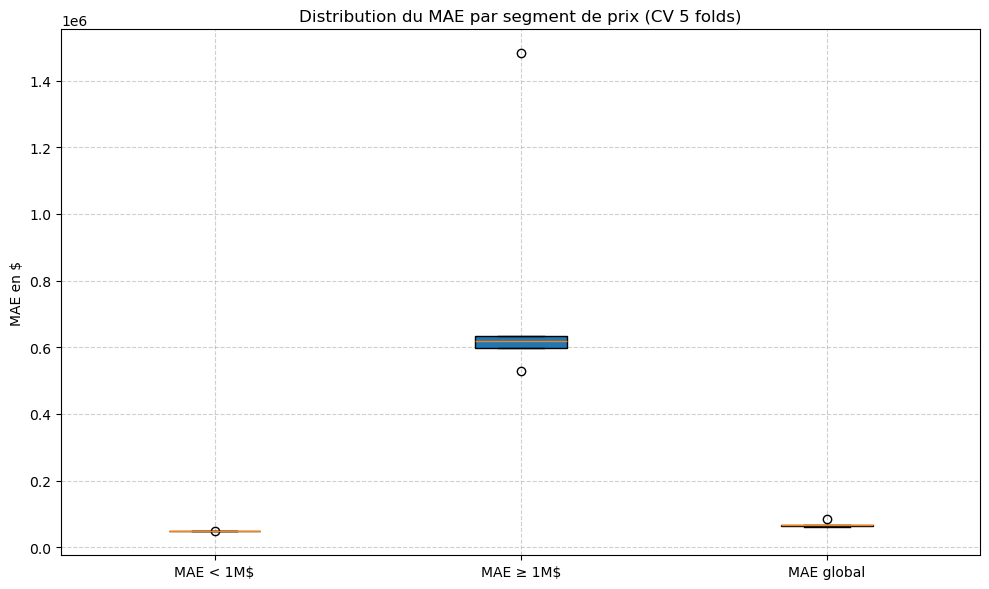

In [16]:
import matplotlib.pyplot as plt

# Préparation des données
data = [
    mae_under_1M_list,
    mae_over_1M_list,
    mae_dollar_scores
]
labels = ['MAE < 1M$', 'MAE ≥ 1M$', 'MAE global']

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels, patch_artist=True)

plt.title("Distribution du MAE par segment de prix (CV 5 folds)")
plt.ylabel("MAE en $")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [17]:
print("La moyenne des maisons de luxe (moins de 3% du dataset) est : ","$",df[df['sale_price'] >= 1_000_000]['sale_price'].mean())


La moyenne des maisons de luxe (moins de 3% du dataset) est :  $ 2035308.1217948718


In [18]:
print("La moyenne des maisons standards (plus de 97% du dataset) est : ","$",df[df['sale_price'] < 1_000_000]['sale_price'].mean())

La moyenne des maisons standards (plus de 97% du dataset) est :  $ 355001.35928688373


In [19]:
print("La moyenne des maisons est :","$",round(df['sale_price'].mean(), 0))

La moyenne des maisons est : $ 401371.0


In [20]:
df_test = pd.read_csv("y_test-v2.csv")
df_test.head()

,log_sale_price
0,12.559897
1,13.281060
2,13.790194
3,12.899197
4,12.745459


In [21]:
df_test["sale_price"]=np.expm1(df_test["log_sale_price"])

In [22]:
df_test.head()

,log_sale_price,sale_price
0,12.559897,284900.0
1,13.281060,585990.0
2,13.790194,975000.0
3,12.899197,399990.0
4,12.745459,342990.0


In [23]:
print("La moyenne des maisons du test est :","$",round(df_test['sale_price'].mean(), 0))

La moyenne des maisons du test est : $ 386098.0


In [24]:
print("La moyenne des maisons de luxe (environ 2% du test) est : ","$",round(df_test[df_test['sale_price'] >= 1_000_000]['sale_price'].mean(),0))

La moyenne des maisons de luxe (environ 2% du test) est :  $ 1794495.0


In [25]:
print("La moyenne des maisons standards (environ 98% du test) est : ","$",round(df_test[df_test['sale_price'] < 1_000_000]['sale_price'].mean(),0))

La moyenne des maisons standards (environ 98% du test) est :  $ 353819.0


In [26]:
pourcentage_luxury = (df_test['sale_price'] >= 1_000_000).mean() * 100
print(f"Part des maisons >= 1M$ du test : {pourcentage_luxury:.2f} %")

Part des maisons >= 1M$ du test : 2.24 %


In [27]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   log_sale_price  848 non-null    float64
 1   sale_price      848 non-null    float64
dtypes: float64(2)
memory usage: 13.4 KB


In [63]:
print("L'erreur relative sur les maisons standards (<1M$, 98% des maisons) du test est :")
print((round(45195*100/353819,1)),"%")

L'erreur relative sur les maisons standards (<1M$, 98% des maisons) du test est :
12.8 %


In [65]:
print("L'erreur relative sur les maisons de luxe (>=1M$, 2% des maisons) du test est :")
print((round(531241*100/1794495,1)),"%")

L'erreur relative sur les maisons de luxe (>=1M$, 2% des maisons) du test est :
29.6 %


In [67]:
print("L'erreur relative sur toutes les maisons du test est :")
print((round(56085*100/386098,1)),"%")

L'erreur relative sur toutes les maisons du test est :
14.5 %


In [31]:
# ======================================
#  SAUVEGARDE DU MODÈLE, DES FEATURES, DES PRÉDICTIONS ET DES POIDS
# ======================================

import joblib
import pandas as pd

# ---  Sauvegarde du modèle ---
joblib.dump(final_model, "xgb_model_trainval.pkl")
print(" Modèle sauvegardé sous 'xgb_model_trainval.pkl'")

# ---  Sauvegarde de la liste exacte des features ---
with open("features_trainval.txt", "w") as f:
    for col in X_final_train.columns:
        f.write(col + "\n")
print(" Liste des features sauvegardée sous 'features_trainval.txt'")

# ---  Sauvegarde des prédictions (et comparaison avec y_train, y_val) ---
# Le modèle a été entraîné sur X_final_train et y_final_train
y_pred_log = final_model.predict(X_final_train)
y_pred_dollar = np.expm1(y_pred_log)
y_true_dollar = np.expm1(y_final_train)

preds_df = pd.DataFrame({
    "y_true_log": y_final_train,
    "y_pred_log": y_pred_log,
    "y_true_dollar": y_true_dollar,
    "y_pred_dollar": y_pred_dollar
})
preds_df.to_csv("predictions_trainval.csv", index=False)
print(f" Fichier 'predictions_trainval.csv' sauvegardé ({len(preds_df)} lignes)")

# ---  Sauvegarde des poids appliqués (sample_weight) ---
# S'ils s'appellent 'weights' ou 'sample_weights' selon ton code :
try:
    weights_series = pd.Series(weights, name="sample_weight")
    weights_series.to_csv("sample_weights_trainval.csv", index=False)
    print(f" Fichier 'sample_weights_trainval.csv' sauvegardé ({len(weights_series)} poids)")
except NameError:
    print(" Variable 'weights' introuvable. Vérifie le nom exact utilisé dans ton notebook (ex: sample_weights).")

print("\n Tous les fichiers nécessaires au déploiement sont prêts.")


 Modèle sauvegardé sous 'xgb_model_trainval.pkl'
 Liste des features sauvegardée sous 'features_trainval.txt'
 Fichier 'predictions_trainval.csv' sauvegardé (4805 lignes)
 Fichier 'sample_weights_trainval.csv' sauvegardé (4805 poids)

 Tous les fichiers nécessaires au déploiement sont prêts.
